<a href="https://colab.research.google.com/github/hanaph/fraud_detection/blob/main/fraud_detection_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏦 Détection de Fraude Bancaire par Machine Learning

**Master Finance Digitale - DIT Dakar**

**Auteur:** Hanaphiou Deen Diallo  
**Date:** Novembre 2025

---

## Objectif
Construire un modèle de classification pour détecter les transactions frauduleuses par chèque, en optimisant la **F-mesure**.

## Plan du Notebook
1. Imports et Configuration
2. Chargement et Exploration des Données
3. Prétraitement et Feature Engineering
4. Méthodes de Rééchantillonnage
5. Entraînement des Modèles
6. Évaluation et Comparaison
7. Méthodes d'Ensemble
8. Conclusions

---
## 1. Imports et Configuration

In [4]:
# Imports principaux
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print(" Librairies de base importées")

 Librairies de base importées


In [5]:
# Prétraitement
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.base import clone

print(" Modules de prétraitement importés")

 Modules de prétraitement importés


In [6]:
# Rééchantillonnage
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN

print(" Modules de rééchantillonnage importés")

 Modules de rééchantillonnage importés


In [7]:
# Algorithmes de classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              AdaBoostClassifier, VotingClassifier, BaggingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

print(" Algorithmes de classification importés")

 Algorithmes de classification importés


In [8]:
# XGBoost et LightGBM
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
    print(" XGBoost disponible")
except ImportError:
    XGBOOST_AVAILABLE = False
    print(" XGBoost non disponible")

try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
    print(" LightGBM disponible")
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print(" LightGBM non disponible")

 XGBoost disponible
 LightGBM disponible


In [9]:
# Métriques d'évaluation
from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             precision_score, recall_score, accuracy_score,
                             roc_auc_score, roc_curve)

print(" Métriques importées")

 Métriques importées


In [10]:
# Configuration globale
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

COLORS = {'normal': '#2ecc71', 'fraud': '#e74c3c'}

print(f" Configuration terminée (Random State: {RANDOM_STATE})")

 Configuration terminée (Random State: 42)


---
## 2. Chargement et Exploration des Données

In [11]:
# =============================================================================
# CHARGEMENT DES DONNÉES (AVEC ÉCHANTILLONNAGE OPTIONNEL)
# =============================================================================

import pickle
import os
from sklearn.model_selection import train_test_split

# Configuration
SAMPLE_RATIO = 1.0  # 50% des données (change à 1.0 pour 100%)
CACHE_PATH = f"/content/df_cache_{int(SAMPLE_RATIO*100)}pct.pkl"
FORCE_RELOAD = False  # Mettre True pour recharger

if os.path.exists(CACHE_PATH) and not FORCE_RELOAD:
    print("⚡ Chargement depuis le cache...")
    with open(CACHE_PATH, 'rb') as f:
        df = pickle.load(f)
    print(f"✅ Données chargées: {df.shape[0]:,} lignes")

else:
    print("📂 Chargement depuis Excel...")

    df_full = pd.read_excel(
        "/content/drive/MyDrive/Examen ML/fraude_dataset.xlsx",
        parse_dates=['DateTransaction']
    )

    print(f"   Dataset complet: {df_full.shape[0]:,} lignes")

    # Échantillonnage stratifié (si SAMPLE_RATIO < 1.0)
    if SAMPLE_RATIO < 1.0:
        print(f"   📊 Échantillonnage stratifié ({SAMPLE_RATIO*100:.0f}%)...")
        df, _ = train_test_split(
            df_full,
            train_size=SAMPLE_RATIO,
            stratify=df_full['FlagImpaye'],
            random_state=42
        )
        print(f"   ✅ Échantillon: {df.shape[0]:,} lignes")
    else:
        df = df_full
        print(f"   ✅ 100% des données conservées")

    # Sauvegarder en cache
    with open(CACHE_PATH, 'wb') as f:
        pickle.dump(df, f)

    print(f"✅ Données sauvegardées en cache")

# Résumé
print(f"\n📋 RÉSUMÉ DES DONNÉES")
print(f"="*50)
print(f"   Lignes:      {df.shape[0]:,}")
print(f"   Colonnes:    {df.shape[1]}")
print(f"   Période:     {df['DateTransaction'].min().strftime('%Y-%m-%d')} → {df['DateTransaction'].max().strftime('%Y-%m-%d')}")
print(f"   Fraudes:     {df['FlagImpaye'].sum():,} ({df['FlagImpaye'].mean()*100:.2f}%)")
print(f"   Non-fraudes: {(df['FlagImpaye']==0).sum():,} ({(df['FlagImpaye']==0).mean()*100:.2f}%)")

📂 Chargement depuis Excel...
   Dataset complet: 1,048,575 lignes
   ✅ 100% des données conservées
✅ Données sauvegardées en cache

📋 RÉSUMÉ DES DONNÉES
   Lignes:      1,048,575
   Colonnes:    23
   Période:     2017-02-01 → 2017-03-24
   Fraudes:     3,795 (0.36%)
   Non-fraudes: 1,044,780 (99.64%)


In [12]:
# Aperçu des données
df.head()

,ZIBZIN,IDAvisAutorisationCheque,FlagImpaye,Montant,DateTransaction,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,...,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Heure
0,A013010004908126703060931,78643044,0,20.00,2017-02-01 07:32:14,1,0,0,0,551,...,37.186668,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,27134
1,A013011306908024927155000,78643045,0,20.00,2017-02-01 07:43:37,1,0,0,0,551,...,48.844716,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,27817
2,A013010002908283134592527,78643046,0,57.64,2017-02-01 07:47:38,1,0,0,0,549,...,73.118280,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,28058
3,A011010002908105209831316,78643047,0,54.29,2017-02-01 07:48:48,0,1,1,1,267,...,110.056926,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,28128
4,A013010041908000125652029,78643048,0,26.90,2017-02-01 08:13:27,1,0,0,0,549,...,45.368313,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,29607


In [13]:
# Types de données
df.dtypes

,0
ZIBZIN,object
IDAvisAutorisationCheque,int64
FlagImpaye,int64
Montant,float64
DateTransaction,datetime64[ns]
CodeDecision,int64
VerifianceCPT1,int64
VerifianceCPT2,int64
VerifianceCPT3,int64
D2CB,int64


In [14]:
# Valeurs manquantes
missing = df.isnull().sum()
print("Valeurs manquantes:")
print(missing[missing > 0] if missing.sum() > 0 else "Aucune valeur manquante ")

Valeurs manquantes:
Aucune valeur manquante 


In [15]:
# Distribution de la variable cible
print(" Distribution de FlagImpaye:")
print("="*40)
target_dist = df['FlagImpaye'].value_counts()
target_pct = df['FlagImpaye'].value_counts(normalize=True) * 100

print(f"Classe 0 (Normal): {target_dist[0]:,} ({target_pct[0]:.2f}%)")
print(f"Classe 1 (Fraude): {target_dist[1]:,} ({target_pct[1]:.2f}%)")
print(f"\n Ratio déséquilibre: 1:{target_dist[0]//target_dist[1]}")

 Distribution de FlagImpaye:
Classe 0 (Normal): 1,044,780 (99.64%)
Classe 1 (Fraude): 3,795 (0.36%)

 Ratio déséquilibre: 1:275


In [16]:
# Statistiques descriptives
df.describe()

,IDAvisAutorisationCheque,FlagImpaye,Montant,DateTransaction,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,ScoringFP1,...,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Heure
count,1.048575e+06,1.048575e+06,1.048575e+06,1048575,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,...,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,7.917316e+07,3.619197e-03,5.859746e+01,2017-02-26 15:27:04.363031808,5.799919e-01,1.670906e-01,1.777460e-01,1.959202e-01,4.036095e+02,1.167020e+00,...,3.804212e+01,3.821160e+01,1.102460e+04,1.040603e+00,3.764990e+00,4.077673e+00,4.114227e+00,6.624179e+01,7.644329e+00,5.117350e+04
min,7.864304e+07,0.000000e+00,2.000000e-02,2017-02-01 07:32:14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,8.101852e-05,3.703704e-04,1.400463e-03,2.000000e-02,0.000000e+00,2.272700e+04
25%,7.890819e+07,0.000000e+00,2.619000e+01,2017-02-14 10:06:17.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.020000e+02,4.818677e-03,...,2.219592e+01,2.863473e+01,0.000000e+00,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,2.998000e+01,0.000000e+00,4.036000e+04
50%,7.917303e+07,0.000000e+00,4.395000e+01,2017-02-25 16:56:33,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.210000e+02,7.960894e-03,...,3.425713e+01,3.681303e+01,0.000000e+00,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.996000e+01,0.000000e+00,5.160500e+04
75%,7.943833e+07,0.000000e+00,7.241000e+01,2017-03-11 09:16:27,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.460000e+02,1.539683e-02,...,4.641641e+01,5.057974e+01,0.000000e+00,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,8.297000e+01,0.000000e+00,6.142700e+04
max,7.970327e+07,1.000000e+00,1.560000e+04,2017-03-24 13:04:46,3.000000e+00,8.000000e+00,2.200000e+01,2.500000e+01,5.510000e+02,1.230582e+04,...,1.000000e+04,1.276970e+02,9.956167e+06,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,1.560000e+04,7.550540e+03,8.190400e+04
std,3.060671e+05,6.005083e-02,6.712235e+01,NaN,5.000884e-01,3.895026e-01,4.334002e-01,5.014135e-01,2.005363e+02,2.295438e+01,...,5.666644e+01,1.620979e+01,2.270066e+05,2.003463e-01,1.034184e+00,4.602106e-01,3.509394e-01,8.147398e+01,3.917383e+01,1.170081e+04


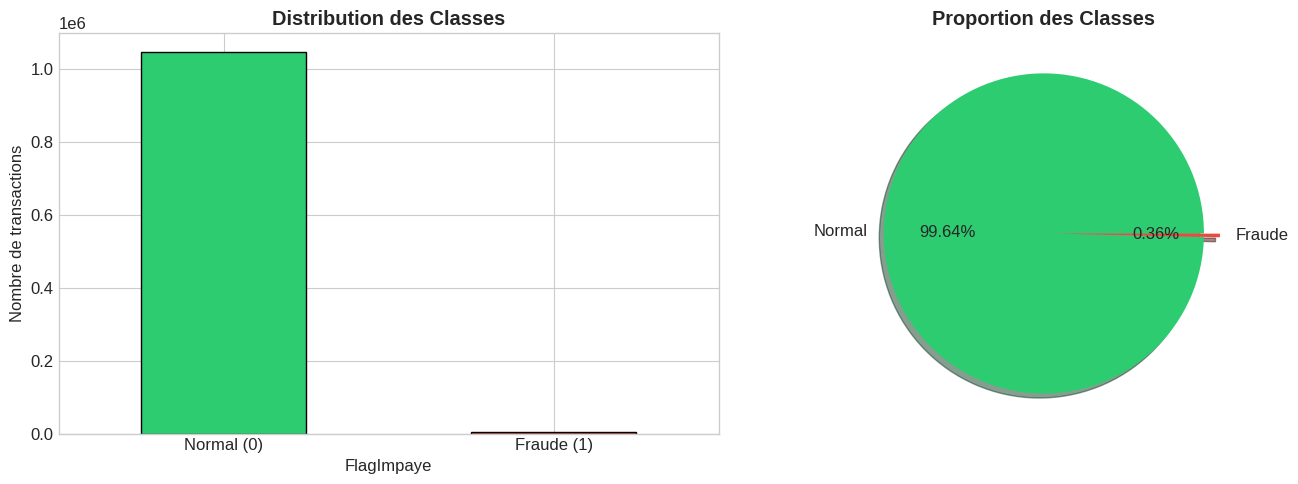

In [17]:
# Visualisation: Distribution des classes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = [COLORS['normal'], COLORS['fraud']]
target_dist.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black')
axes[0].set_title('Distribution des Classes', fontweight='bold')
axes[0].set_xticklabels(['Normal (0)', 'Fraude (1)'], rotation=0)
axes[0].set_ylabel('Nombre de transactions')

# Pie chart
axes[1].pie(target_dist, labels=['Normal', 'Fraude'], autopct='%1.2f%%',
            colors=colors, explode=[0, 0.1], shadow=True)
axes[1].set_title('Proportion des Classes', fontweight='bold')

plt.tight_layout()
plt.savefig('distribution_classes.png', dpi=300)
plt.show()

Ce graphique illustre le déséquilibre extrême des classes dans notre dataset :
- 99.64% de transactions normales (~1,045,000 transactions)
- 0.36% de transactions frauduleuses (~3,800 transactions)

Ce ratio de 1:277 représente un défi majeur pour les algorithmes de
classification, car ils tendent naturellement à prédire la classe majoritaire.
C'est pourquoi des techniques comme le rééchantillonnage (SMOTE) ou
l'ajustement des poids (scale_pos_weight) sont nécessaires.

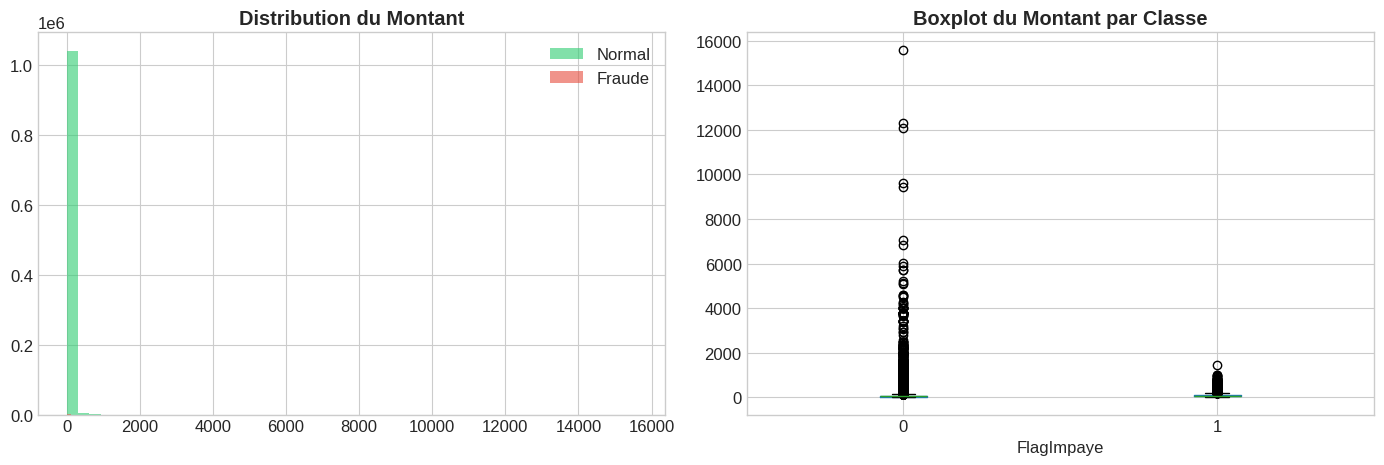

In [18]:
# Visualisation: Distribution du montant
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df[df['FlagImpaye']==0]['Montant'].hist(bins=50, alpha=0.6, ax=axes[0], color=COLORS['normal'], label='Normal')
df[df['FlagImpaye']==1]['Montant'].hist(bins=50, alpha=0.6, ax=axes[0], color=COLORS['fraud'], label='Fraude')
axes[0].set_title('Distribution du Montant', fontweight='bold')
axes[0].legend()

df.boxplot(column='Montant', by='FlagImpaye', ax=axes[1])
axes[1].set_title('Boxplot du Montant par Classe', fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.savefig('distribution_montant.png', dpi=300)
plt.show()

Analyse de la distribution du montant des transactions :

- La majorité des transactions (normales et frauduleuses) ont des montants
  faibles, concentrés entre 0 et 2000€.

- Les transactions normales présentent plus d'outliers avec des montants
  élevés (jusqu'à 15000€), tandis que les fraudes restent généralement
  en dessous de 1500€.

- Observation clé : Les fraudeurs semblent éviter les montants très élevés,
  probablement pour ne pas déclencher d'alertes automatiques.

Cette variable "Montant" seule ne suffit pas à distinguer les fraudes,
d'où l'importance du feature engineering et des variables comportementales.

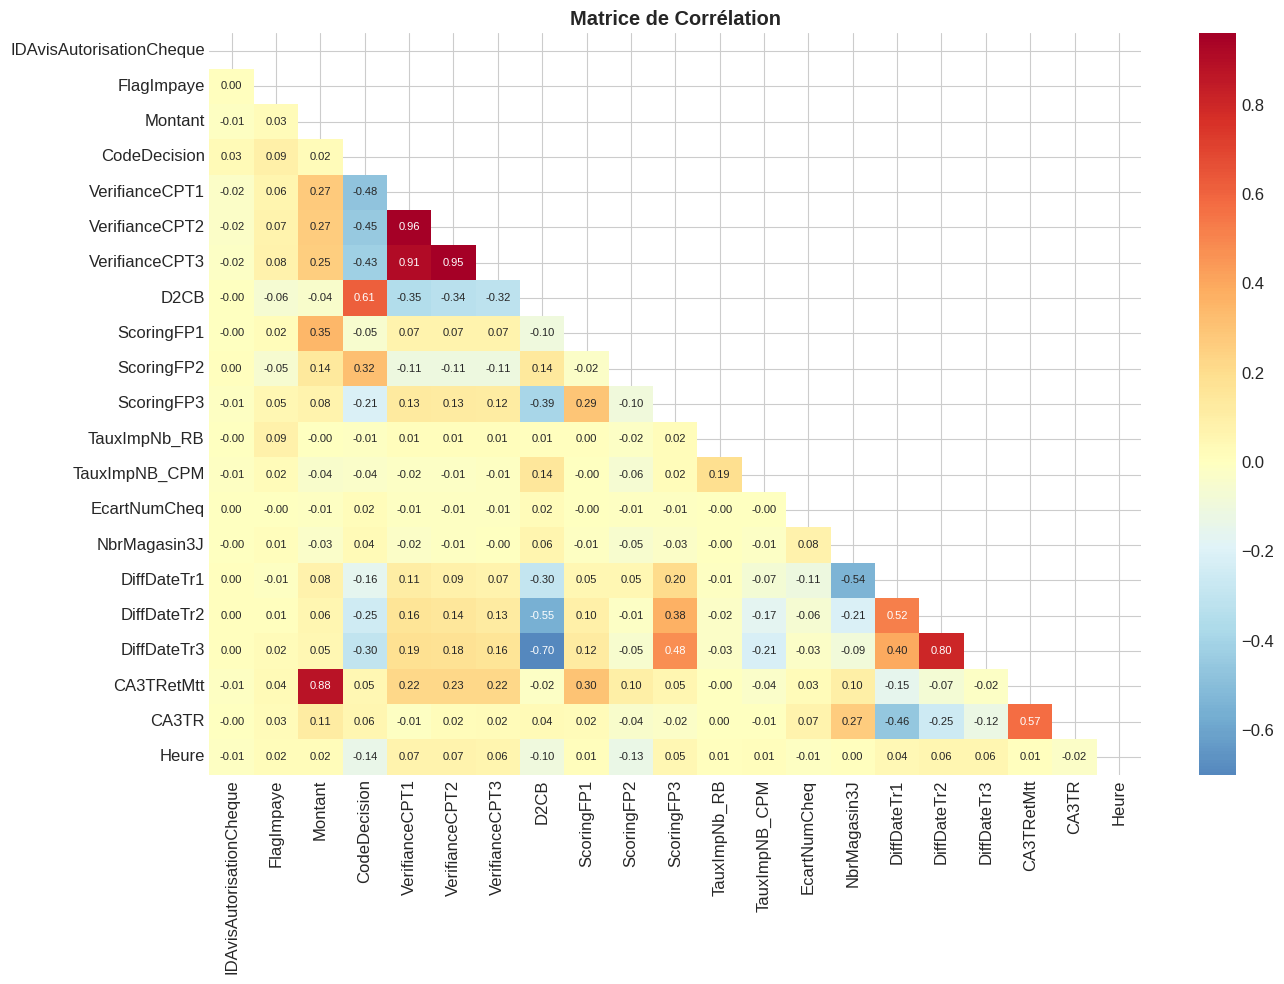

In [19]:
# Matrice de corrélation
fig, ax = plt.subplots(figsize=(14, 10))

numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, ax=ax, annot_kws={'size': 8})
ax.set_title('Matrice de Corrélation', fontweight='bold')

plt.tight_layout()
plt.savefig('matrice_correlation.png', dpi=300)
plt.show()

Analyse de la matrice de corrélation :

Corrélations avec la variable cible (FlagImpaye) :
- Les corrélations sont faibles (< 0.10), ce qui est typique en détection
  de fraude où les patterns sont subtils et non-linéaires.
- Variables les plus corrélées : CodeDecision (0.09), VerifianceCPT3 (0.08),
  CA3TRetMtt (0.04)

Multicolinéarité détectée :
- VerifianceCPT1, CPT2, CPT3 sont très corrélées entre elles (0.91-0.96)
- DiffDateTr1, Tr2, Tr3 sont corrélées (0.52-0.80)
- Action : Suppression de VerifianceCPT1 et CPT2 pour éviter la redondance

Cette analyse justifie l'utilisation d'algorithmes non-linéaires (XGBoost)
capables de capturer des relations complexes entre les variables.

In [20]:
# Corrélations avec la variable cible
print("🔗 Corrélations avec FlagImpaye:")
correlations = corr_matrix['FlagImpaye'].drop('FlagImpaye').sort_values(key=abs, ascending=False)
for feat, corr in correlations.head(10).items():
    print(f"   {feat:25}: {corr:+.4f}")

🔗 Corrélations avec FlagImpaye:
   CodeDecision             : +0.0916
   TauxImpNb_RB             : +0.0876
   VerifianceCPT3           : +0.0796
   VerifianceCPT2           : +0.0745
   VerifianceCPT1           : +0.0621
   D2CB                     : -0.0581
   ScoringFP2               : -0.0521
   ScoringFP3               : +0.0504
   CA3TRetMtt               : +0.0350
   Montant                  : +0.0274


---
## 3. Prétraitement et Feature Engineering

In [21]:
df_processed = df.copy()
print("Copie créée pour le prétraitement")

Copie créée pour le prétraitement


In [22]:
# Colonnes à supprimer (non prédictives)
cols_to_drop = ['ZIBZIN', 'IDAvisAutorisationCheque', 'CodeDecision']
cols_to_drop = [c for c in cols_to_drop if c in df_processed.columns]

print(f" Colonnes à exclure: {cols_to_drop}")
print("\n Raisons:")
print("   - ZIBZIN: identifiant (pas de pouvoir prédictif)")
print("   - IDAvisAutorisationCheque: identifiant unique")
print("   - CodeDecision: info POST-transaction (data leakage)")

 Colonnes à exclure: ['ZIBZIN', 'IDAvisAutorisationCheque', 'CodeDecision']

 Raisons:
   - ZIBZIN: identifiant (pas de pouvoir prédictif)
   - IDAvisAutorisationCheque: identifiant unique
   - CodeDecision: info POST-transaction (data leakage)


In [23]:
# Feature Engineering: Variables temporelles
print("Création de features temporelles...")

df_processed['DayOfWeek'] = df_processed['DateTransaction'].dt.dayofweek
df_processed['DayOfMonth'] = df_processed['DateTransaction'].dt.day
df_processed['Month'] = df_processed['DateTransaction'].dt.month
df_processed['IsWeekend'] = (df_processed['DayOfWeek'] >= 5).astype(int)

print("  DayOfWeek, DayOfMonth, Month, IsWeekend créées")

Création de features temporelles...
  DayOfWeek, DayOfMonth, Month, IsWeekend créées


In [24]:
# Feature Engineering: Variables comportementales
print("🔧 Création de features comportementales...")

# Ratio montant / fréquence
df_processed['MontantParTransaction3J'] = df_processed['Montant'] / (df_processed['VerifianceCPT2'] + 1)

# Score global d'anormalité
df_processed['ScoringGlobal'] = (df_processed['ScoringFP1'] + df_processed['ScoringFP2'] + df_processed['ScoringFP3']) / 3

# Indicateur fréquence élevée
df_processed['FrequenceElevee'] = (df_processed['VerifianceCPT1'] > 2).astype(int)

print(" MontantParTransaction3J, ScoringGlobal, FrequenceElevee créées")

🔧 Création de features comportementales...
 MontantParTransaction3J, ScoringGlobal, FrequenceElevee créées


Feature Engineering

In [25]:
# =============================================================================
# FEATURE ENGINEERING AVANCÉ
# =============================================================================

print("🔧 Création de features avancées...")

def log_feature(df, feature_name):
    print(f"   ➤ {feature_name}: "
          f"min={df[feature_name].min():.4f}, "
          f"max={df[feature_name].max():.4f}, "
          f"mean={df[feature_name].mean():.4f}, "
          f"nonnull={df[feature_name].notnull().mean()*100:.2f}%")

# 1. Ratio montant actuel vs historique
df_processed['RatioMontantHistorique'] = df_processed['Montant'] / (df_processed['CA3TR'] + 1)
log_feature(df_processed, 'RatioMontantHistorique')

# 2. Vélocité des transactions (fréquence / temps)
df_processed['VelociteTransaction'] = df_processed['VerifianceCPT3'] / (df_processed['D2CB'] + 1)
log_feature(df_processed, 'VelociteTransaction')

# 3. Anomalie de fréquence (écart à la moyenne)
df_processed['AnomalieFrequence'] = df_processed['VerifianceCPT1'] - df_processed['VerifianceCPT3'] / 7
log_feature(df_processed, 'AnomalieFrequence')

# 4. Score de risque combiné
df_processed['ScoreRisqueCombine'] = (
    df_processed['ScoringFP1'] * 0.4 +
    df_processed['ScoringFP2'] * 0.3 +
    df_processed['ScoringFP3'] * 0.3
)
log_feature(df_processed, 'ScoreRisqueCombine')

# 5. Indicateur nouveau client (D2CB faible)
df_processed['NouveauClient'] = (df_processed['D2CB'] < 30).astype(int)
log_feature(df_processed, 'NouveauClient')

# 6. Montant anormalement élevé (> 2 écarts-types)
montant_mean = df_processed['Montant'].mean()
montant_std = df_processed['Montant'].std()
df_processed['MontantAnormal'] = (df_processed['Montant'] > montant_mean + 2*montant_std).astype(int)
log_feature(df_processed, 'MontantAnormal')

# 7. Activité multi-magasins suspecte
df_processed['MultiMagasinSuspect'] = (df_processed['NbrMagasin3J'] > 3).astype(int)
log_feature(df_processed, 'MultiMagasinSuspect')

print("✅ 7 nouvelles features créées avec logs")


🔧 Création de features avancées...
   ➤ RatioMontantHistorique: min=0.0029, max=15600.0000, mean=52.5294, nonnull=100.00%
   ➤ VelociteTransaction: min=0.0000, max=8.5000, mean=0.0267, nonnull=100.00%
   ➤ AnomalieFrequence: min=-1.5714, max=6.8571, mean=0.1391, nonnull=100.00%
   ➤ ScoreRisqueCombine: min=-14.2140, max=4922.4939, mean=1.7752, nonnull=100.00%
   ➤ NouveauClient: min=0.0000, max=1.0000, mean=0.1370, nonnull=100.00%
   ➤ MontantAnormal: min=0.0000, max=1.0000, mean=0.0236, nonnull=100.00%
   ➤ MultiMagasinSuspect: min=0.0000, max=1.0000, mean=0.0000, nonnull=100.00%
✅ 7 nouvelles features créées avec logs


In [26]:
# =============================================================================
# SUPPRESSION DES VARIABLES REDONDANTES
# =============================================================================

# Variables à supprimer (forte multicolinéarité)
cols_multicollineaires = ['VerifianceCPT1', 'VerifianceCPT2']  # Garder VerifianceCPT3

# Vérifier si elles existent
cols_to_remove = [c for c in cols_multicollineaires if c in df_processed.columns]

if cols_to_remove:
    df_processed = df_processed.drop(columns=cols_to_remove)
    print(f"✅ Colonnes supprimées (multicolinéarité): {cols_to_remove}")
else:
    print("✅ Aucune colonne redondante à supprimer")

print(f"📊 Colonnes restantes: {df_processed.shape[1]}")

✅ Colonnes supprimées (multicolinéarité): ['VerifianceCPT1', 'VerifianceCPT2']
📊 Colonnes restantes: 35


In [27]:
# Séparation temporelle Train/Test
print(" Séparation temporelle:")

# Vérifier les dates réelles dans ton dataset
date_min = df_processed['DateTransaction'].min()
date_max = df_processed['DateTransaction'].max()
print(f"   Période des données: {date_min.strftime('%Y-%m-%d')} → {date_max.strftime('%Y-%m-%d')}")

# Calculer la date de séparation (70% train / 30% test)
total_days = (date_max - date_min).days
split_date = date_min + pd.Timedelta(days=int(total_days * 0.8))

print(f"   Date de séparation: {split_date.strftime('%Y-%m-%d')}")
print(f"   Train: {date_min.strftime('%Y-%m-%d')} → {split_date.strftime('%Y-%m-%d')}")
print(f"   Test:  {split_date.strftime('%Y-%m-%d')} → {date_max.strftime('%Y-%m-%d')}")

# Séparation
train_mask = df_processed['DateTransaction'] < split_date
test_mask = df_processed['DateTransaction'] >= split_date

df_train = df_processed[train_mask].copy()
df_test = df_processed[test_mask].copy()

print(f"\n Train: {len(df_train):,} ({len(df_train)/len(df_processed)*100:.1f}%)")
print(f" Test:  {len(df_test):,} ({len(df_test)/len(df_processed)*100:.1f}%)")

# Vérifier la distribution des fraudes
print(f"\n Distribution des fraudes:")
print(f"   Train: {df_train['FlagImpaye'].mean()*100:.2f}%")
print(f"   Test:  {df_test['FlagImpaye'].mean()*100:.2f}%")

 Séparation temporelle:
   Période des données: 2017-02-01 → 2017-03-24
   Date de séparation: 2017-03-13
   Train: 2017-02-01 → 2017-03-13
   Test:  2017-03-13 → 2017-03-24

 Train: 816,314 (77.8%)
 Test:  232,261 (22.2%)

 Distribution des fraudes:
   Train: 0.36%
   Test:  0.37%


In [28]:
# Préparation des features
feature_cols = [c for c in df_processed.columns
               if c not in cols_to_drop + ['DateTransaction', 'FlagImpaye']]

print(f" {len(feature_cols)} features sélectionnées:")
for i, col in enumerate(feature_cols, 1):
    print(f"   {i:2}. {col}")

 30 features sélectionnées:
    1. Montant
    2. VerifianceCPT3
    3. D2CB
    4. ScoringFP1
    5. ScoringFP2
    6. ScoringFP3
    7. TauxImpNb_RB
    8. TauxImpNB_CPM
    9. EcartNumCheq
   10. NbrMagasin3J
   11. DiffDateTr1
   12. DiffDateTr2
   13. DiffDateTr3
   14. CA3TRetMtt
   15. CA3TR
   16. Heure
   17. DayOfWeek
   18. DayOfMonth
   19. Month
   20. IsWeekend
   21. MontantParTransaction3J
   22. ScoringGlobal
   23. FrequenceElevee
   24. RatioMontantHistorique
   25. VelociteTransaction
   26. AnomalieFrequence
   27. ScoreRisqueCombine
   28. NouveauClient
   29. MontantAnormal
   30. MultiMagasinSuspect


In [29]:
# Extraction X et y
X_train = df_train[feature_cols].copy()
y_train = df_train['FlagImpaye'].copy()
X_test = df_test[feature_cols].copy()
y_test = df_test['FlagImpaye'].copy()

print(f" X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f" X_test:  {X_test.shape}  | y_test:  {y_test.shape}")

 X_train: (816314, 30) | y_train: (816314,)
 X_test:  (232261, 30)  | y_test:  (232261,)


In [30]:
# Gestion des valeurs manquantes
if X_train.isnull().sum().sum() > 0:
    train_medians = X_train.median()
    X_train = X_train.fillna(train_medians)
    X_test = X_test.fillna(train_medians)
    print(" Valeurs manquantes remplies par la médiane")
else:
    print(" Aucune valeur manquante")

 Aucune valeur manquante


In [31]:
# Normalisation
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_cols, index=X_test.index)

print("✅ Normalisation terminée (StandardScaler)")

✅ Normalisation terminée (StandardScaler)


In [32]:
# Résumé du prétraitement
print("="*50)
print("RÉSUMÉ DU PRÉTRAITEMENT")
print("="*50)
print(f"\nTraining: {X_train_scaled.shape}")
print(f"   Normal: {(y_train==0).sum():,} ({(y_train==0).mean()*100:.2f}%)")
print(f"   Fraude: {(y_train==1).sum():,} ({(y_train==1).mean()*100:.2f}%)")
print(f"\nTest: {X_test_scaled.shape}")
print(f"   Normal: {(y_test==0).sum():,} ({(y_test==0).mean()*100:.2f}%)")
print(f"   Fraude: {(y_test==1).sum():,} ({(y_test==1).mean()*100:.2f}%)")

RÉSUMÉ DU PRÉTRAITEMENT

Training: (816314, 30)
   Normal: 813,368 (99.64%)
   Fraude: 2,946 (0.36%)

Test: (232261, 30)
   Normal: 231,412 (99.63%)
   Fraude: 849 (0.37%)


---
## 4. Méthodes de Rééchantillonnage

In [33]:
sampling_results = {}

# Original
sampling_results['Original'] = (X_train_scaled, y_train)
print(f"1️⃣ Original: {len(y_train):,} samples")

1️⃣ Original: 816,314 samples


In [34]:
# 2. SMOTE
# print("\n2️⃣ SMOTE...")
# smote = SMOTE(random_state=42, k_neighbors=5)
# X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)
# sampling_results['SMOTE'] = (X_smote, y_smote)
# print(f"   ✅ {len(y_smote):,} samples")
# print(f"   Normal: {(y_smote==0).sum():,} | Fraude: {(y_smote==1).sum():,}")

In [35]:
# Résumé des méthodes de sampling
print("\n" + "="*60)
print("RÉSUMÉ DES MÉTHODES DE RÉÉCHANTILLONNAGE")
print("="*60)

for name, (X, y) in sampling_results.items():
    n_fraud = (y == 1).sum()
    n_normal = (y == 0).sum()
    print(f"{name:25} | Total: {len(y):,} | Normal: {n_normal:,} | Fraude: {n_fraud:,}")


RÉSUMÉ DES MÉTHODES DE RÉÉCHANTILLONNAGE
Original                  | Total: 816,314 | Normal: 813,368 | Fraude: 2,946


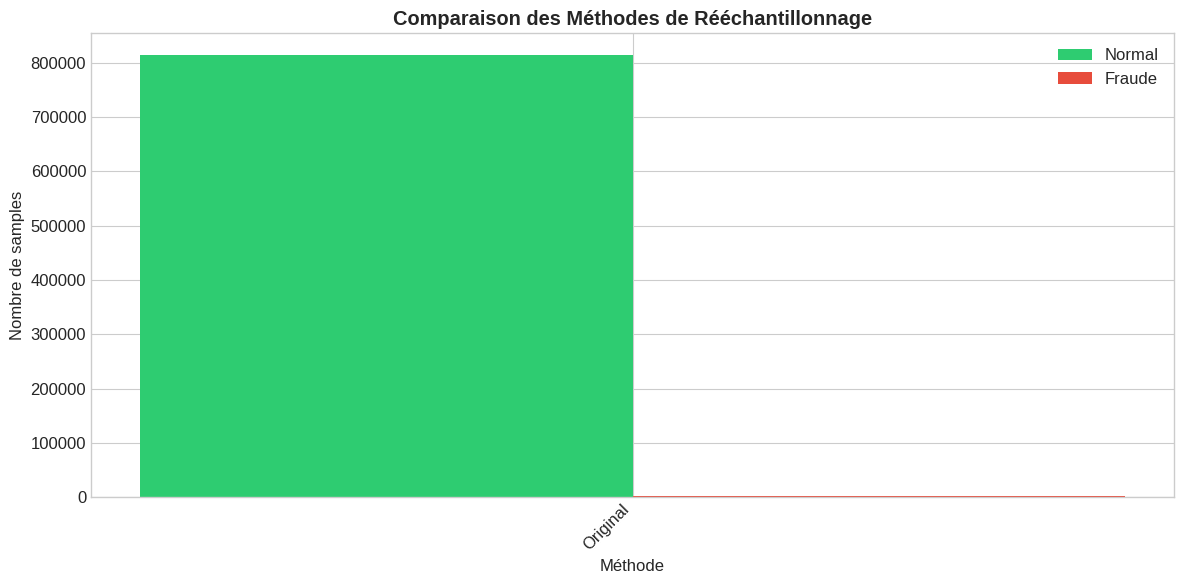

In [36]:
# Visualisation
fig, ax = plt.subplots(figsize=(12, 6))

methods = list(sampling_results.keys())
normal_counts = [(sampling_results[m][1] == 0).sum() for m in methods]
fraud_counts = [(sampling_results[m][1] == 1).sum() for m in methods]

x = np.arange(len(methods))
width = 0.35

ax.bar(x - width/2, normal_counts, width, label='Normal', color=COLORS['normal'])
ax.bar(x + width/2, fraud_counts, width, label='Fraude', color=COLORS['fraud'])

ax.set_xlabel('Méthode')
ax.set_ylabel('Nombre de samples')
ax.set_title('Comparaison des Méthodes de Rééchantillonnage', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.savefig('comparaison_sampling.png', dpi=300)
plt.show()

---
## 5. Définition des Modèles

In [37]:
models = {}

# 1. Régression Logistique
models['LogisticRegression'] = LogisticRegression(
    random_state=RANDOM_STATE, class_weight='balanced', max_iter=1000
)
print("1️⃣ Logistic Regression - Baseline linéaire")

1️⃣ Logistic Regression - Baseline linéaire


In [38]:
# 2. Random Forest
#models['RandomForest'] = RandomForestClassifier(
#    n_estimators=200, max_depth=15, class_weight='balanced',
#    random_state=RANDOM_STATE, n_jobs=-1
#)
#print("2️⃣ Random Forest - Ensemble d'arbres")

In [39]:
# 3. Gradient Boosting
models['GradientBoosting'] = GradientBoostingClassifier(
    n_estimators=150, learning_rate=0.1, max_depth=5,
    random_state=RANDOM_STATE
)
print("3️⃣ Gradient Boosting - Boosting séquentiel")

3️⃣ Gradient Boosting - Boosting séquentiel


In [40]:
# 6. Neural Network
models['NeuralNetwork'] = MLPClassifier(
    hidden_layer_sizes=(128, 64), activation='relu',
    max_iter=500, early_stopping=True, random_state=RANDOM_STATE
)
print("6️⃣ Neural Network - MLP (128→64)")

6️⃣ Neural Network - MLP (128→64)


In [41]:
# 8. XGBoost (si disponible)
if XGBOOST_AVAILABLE:
    models['XGBoost'] = XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        scale_pos_weight=10, random_state=RANDOM_STATE,
        use_label_encoder=False, eval_metric='logloss'
    )
    print("8️⃣ XGBoost - State-of-the-art")

8️⃣ XGBoost - State-of-the-art


In [42]:
print(f"\n✅ Total: {len(models)} modèles à évaluer")
print(f"   {list(models.keys())}")


✅ Total: 4 modèles à évaluer
   ['LogisticRegression', 'GradientBoosting', 'NeuralNetwork', 'XGBoost']


---
## 6. Entraînement et Évaluation

In [43]:
# Fonction d'évaluation
def evaluate_model(model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    y_proba = model.predict_proba(X_te)[:, 1] if hasattr(model, 'predict_proba') else None
    auc = roc_auc_score(y_te, y_proba) if y_proba is not None else None

    return {
        'F1': f1_score(y_te, y_pred),
        'Precision': precision_score(y_te, y_pred),
        'Recall': recall_score(y_te, y_pred),
        'Accuracy': accuracy_score(y_te, y_pred),
        'AUC': auc,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'model': model
    }

print("✅ Fonction d'évaluation définie")

✅ Fonction d'évaluation définie


In [44]:
# Entraînement de tous les modèles
print("🚀 DÉBUT DE L'ENTRAÎNEMENT")
print("="*70)

all_results = []
best_f1 = 0
best_model_info = None

total = len(models) * len(sampling_results)
current = 0

for samp_name, (X_tr, y_tr) in sampling_results.items():
    print(f"\n📊 {samp_name}")

    for model_name, model in models.items():
        current += 1
        print(f"   [{current}/{total}] {model_name}...", end=" ")

        try:
            model_clone = clone(model)
            results = evaluate_model(model_clone, X_tr, y_tr, X_test_scaled, y_test)
            print(f"F1={results['F1']:.4f}")

            all_results.append({
                'Sampling': samp_name,
                'Model': model_name,
                'F1_Score': results['F1'],
                'Precision': results['Precision'],
                'Recall': results['Recall'],
                'AUC': results['AUC']
            })

            if results['F1'] > best_f1:
                best_f1 = results['F1']
                best_model_info = {
                    'name': model_name, 'sampling': samp_name,
                    'f1': results['F1'], 'y_pred': results['y_pred'],
                    'y_proba': results['y_proba'], 'model': results['model']
                }
        except Exception as e:
            print(f"❌ {str(e)[:30]}")

print("\n" + "="*70)
print("✅ ENTRAÎNEMENT TERMINÉ")

🚀 DÉBUT DE L'ENTRAÎNEMENT

📊 Original
   [1/4] LogisticRegression... F1=0.0274
   [2/4] GradientBoosting... F1=0.1060
   [3/4] NeuralNetwork... F1=0.0826
   [4/4] XGBoost... F1=0.2090

✅ ENTRAÎNEMENT TERMINÉ


In [45]:
# Résultats
results_df = pd.DataFrame(all_results).sort_values('F1_Score', ascending=False).reset_index(drop=True)

print(f"🏆 MEILLEUR MODÈLE:")
print(f"   Algorithme: {best_model_info['name']}")
print(f"   Sampling:   {best_model_info['sampling']}")
print(f"   F1-Score:   {best_model_info['f1']:.4f}")

🏆 MEILLEUR MODÈLE:
   Algorithme: XGBoost
   Sampling:   Original
   F1-Score:   0.2090


In [46]:
# Top 15
print("\n🏆 TOP 15 DES MEILLEURS MODÈLES")
results_df.head(15)


🏆 TOP 15 DES MEILLEURS MODÈLES


,Sampling,Model,F1_Score,Precision,Recall,AUC
0,Original,XGBoost,0.209006,0.375000,0.144876,0.870286
1,Original,GradientBoosting,0.106000,0.350993,0.062426,0.858016
2,Original,NeuralNetwork,0.082589,0.787234,0.043581,0.858792
3,Original,LogisticRegression,0.027380,0.013953,0.725559,0.848823


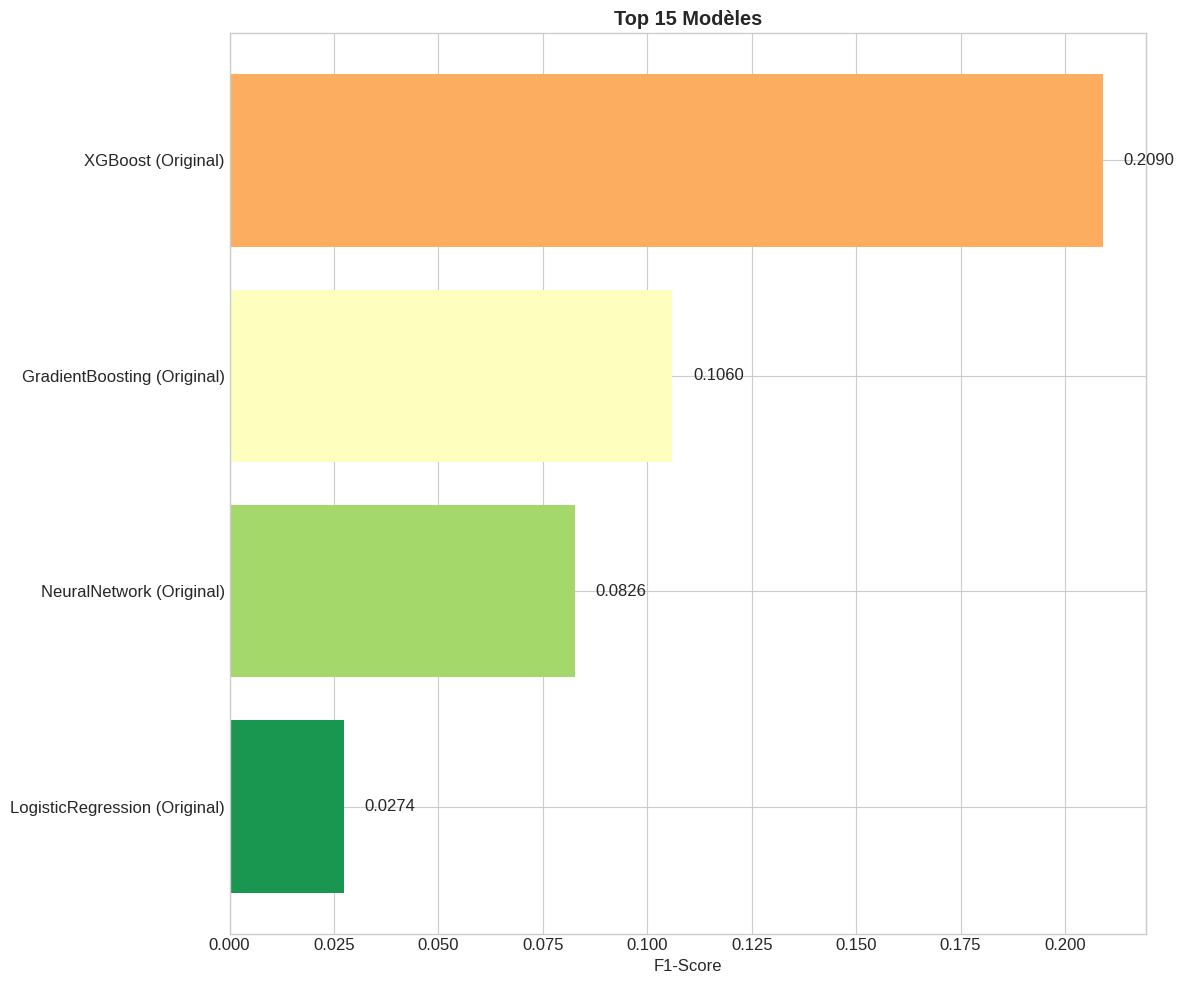

In [47]:
# Visualisation Top 15
fig, ax = plt.subplots(figsize=(12, 10))

top15 = results_df.head(15).copy()
top15['Label'] = top15['Model'] + ' (' + top15['Sampling'] + ')'

colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top15)))
ax.barh(range(len(top15)), top15['F1_Score'], color=colors)
ax.set_yticks(range(len(top15)))
ax.set_yticklabels(top15['Label'])
ax.set_xlabel('F1-Score')
ax.set_title('Top 15 Modèles', fontweight='bold')
ax.invert_yaxis()

for i, v in enumerate(top15['F1_Score']):
    ax.text(v + 0.005, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.savefig('top15_modeles.png', dpi=300)
plt.show()

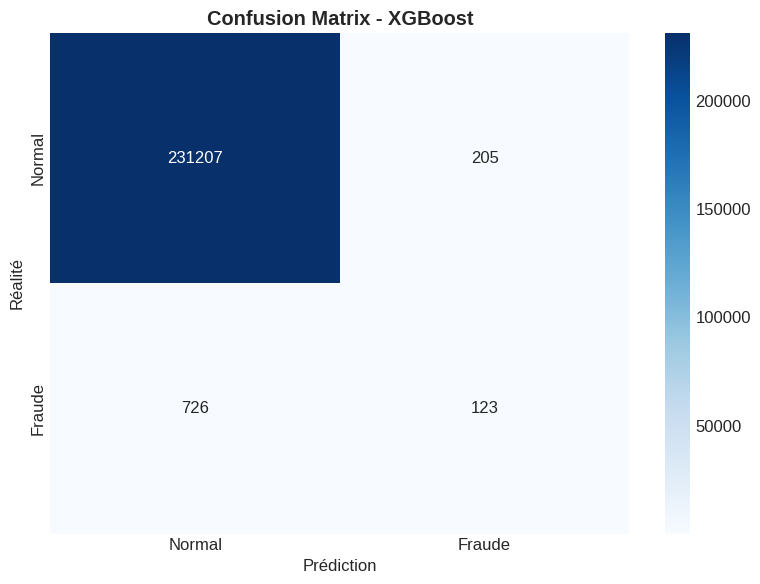

TP: 123 | TN: 231207 | FP: 205 | FN: 726


In [48]:
# Confusion Matrix du meilleur modèle
fig, ax = plt.subplots(figsize=(8, 6))

cm = confusion_matrix(y_test, best_model_info['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
           xticklabels=['Normal', 'Fraude'], yticklabels=['Normal', 'Fraude'])
ax.set_xlabel('Prédiction')
ax.set_ylabel('Réalité')
ax.set_title(f"Confusion Matrix - {best_model_info['name']}", fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"TP: {tp} | TN: {tn} | FP: {fp} | FN: {fn}")

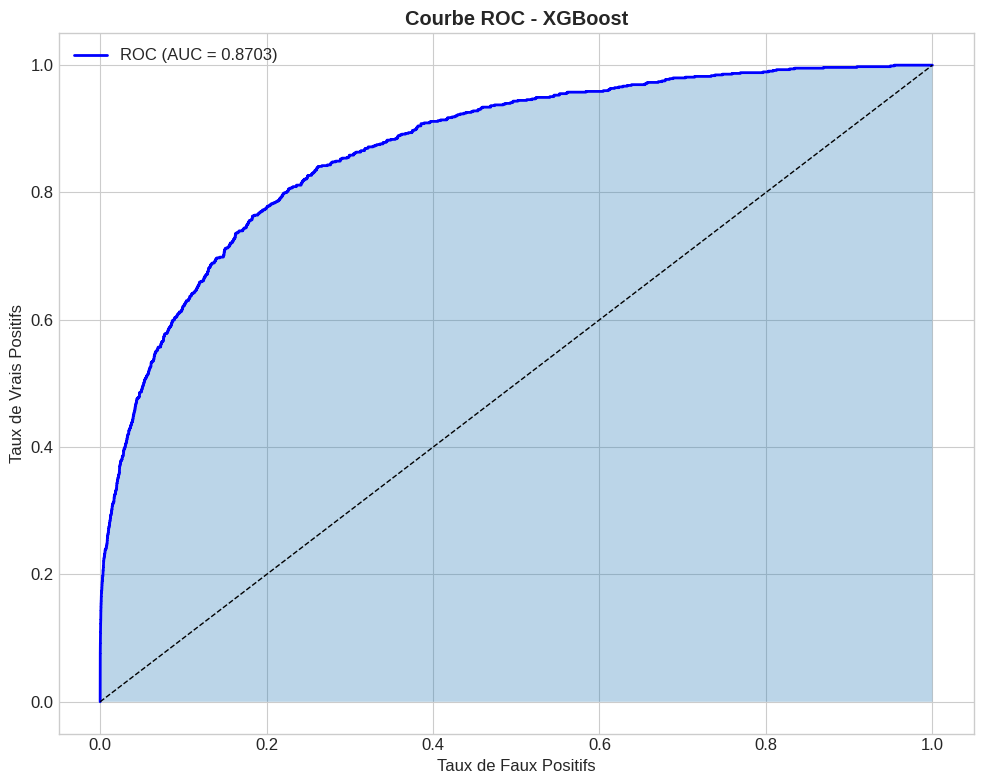

In [49]:
# Courbe ROC
if best_model_info['y_proba'] is not None:
    fig, ax = plt.subplots(figsize=(10, 8))

    fpr, tpr, _ = roc_curve(y_test, best_model_info['y_proba'])
    auc = roc_auc_score(y_test, best_model_info['y_proba'])

    ax.plot(fpr, tpr, 'b-', lw=2, label=f'ROC (AUC = {auc:.4f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.fill_between(fpr, tpr, alpha=0.3)
    ax.set_xlabel('Taux de Faux Positifs')
    ax.set_ylabel('Taux de Vrais Positifs')
    ax.set_title(f"Courbe ROC - {best_model_info['name']}", fontweight='bold')
    ax.legend()

    plt.tight_layout()
    plt.savefig('courbe_roc.png', dpi=300)
    plt.show()

Analyse de la courbe ROC - XGBoost :

- AUC = 0.8703 (87.03%) → Excellent pouvoir discriminant

- La courbe bleue est bien au-dessus de la diagonale (ligne pointillée),
  ce qui indique que le modèle distingue efficacement les fraudes des
  transactions normales.

- Interprétation de l'AUC :
  - 0.5 = modèle aléatoire (aucun pouvoir prédictif)
  - 0.7-0.8 = bon modèle
  - 0.8-0.9 = très bon modèle ✓
  - 0.9-1.0 = excellent modèle

- En pratique : Si on prend une transaction frauduleuse et une normale
  au hasard, le modèle attribue un score de risque plus élevé à la fraude
  dans 87% des cas.

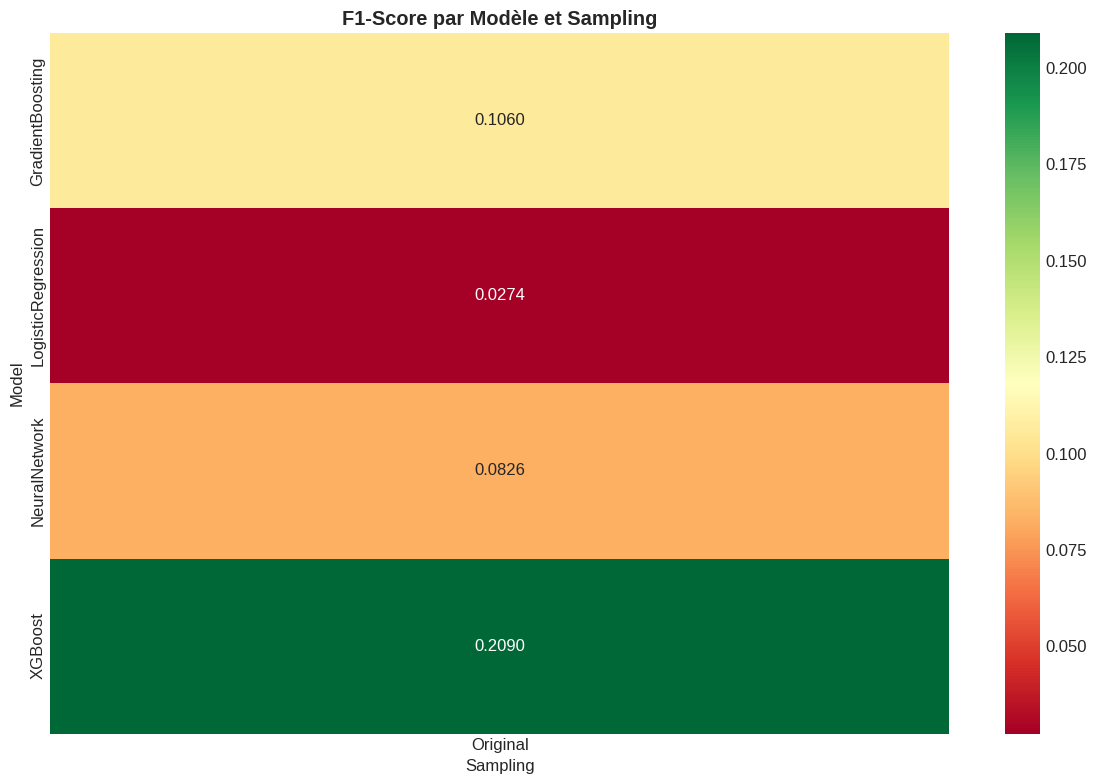

In [50]:
# Heatmap Modèle x Sampling
fig, ax = plt.subplots(figsize=(12, 8))

pivot = results_df.pivot_table(values='F1_Score', index='Model', columns='Sampling')
sns.heatmap(pivot, annot=True, fmt='.4f', cmap='RdYlGn', ax=ax)
ax.set_title('F1-Score par Modèle et Sampling', fontweight='bold')

plt.tight_layout()
plt.savefig('heatmap_resultats.png', dpi=300)
plt.show()

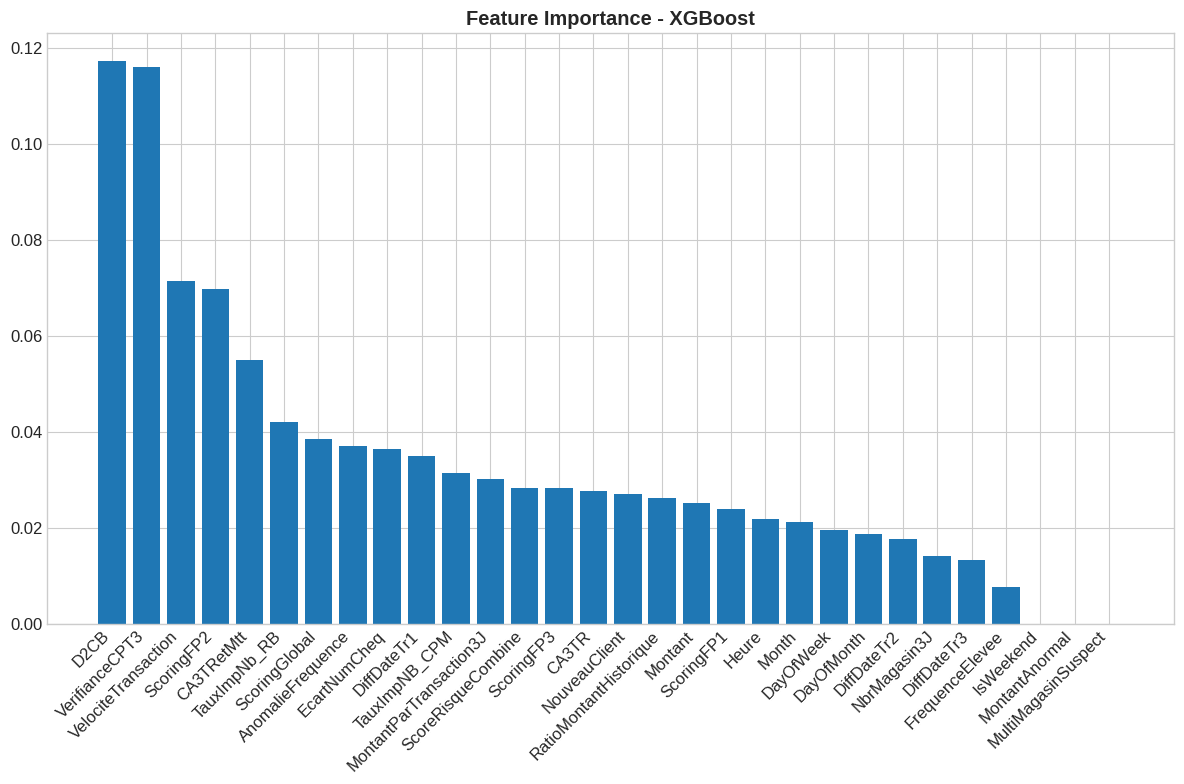


Top 10 Features:
   D2CB: 0.1172
   VerifianceCPT3: 0.1160
   VelociteTransaction: 0.0715
   ScoringFP2: 0.0697
   CA3TRetMtt: 0.0550
   TauxImpNb_RB: 0.0420
   ScoringGlobal: 0.0386
   AnomalieFrequence: 0.0371
   EcartNumCheq: 0.0364
   DiffDateTr1: 0.0349


In [51]:
# Feature Importance
if hasattr(best_model_info['model'], 'feature_importances_'):
    importance = best_model_info['model'].feature_importances_
    indices = np.argsort(importance)[::-1]

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.bar(range(len(importance)), importance[indices])
    ax.set_xticks(range(len(importance)))
    ax.set_xticklabels([feature_cols[i] for i in indices], rotation=45, ha='right')
    ax.set_title(f"Feature Importance - {best_model_info['name']}", fontweight='bold')

    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300)
    plt.show()

    print("\nTop 10 Features:")
    for i in range(min(10, len(importance))):
        print(f"   {feature_cols[indices[i]]}: {importance[indices[i]]:.4f}")

In [52]:
# =============================================================================
# OPTIMISATION COMPLÈTE DE XGBOOST
# =============================================================================

print("🚀 OPTIMISATION XGBOOST")
print("="*70)

# -----------------------------------------------------------------------------
# ÉTAPE 1 : Test des poids (scale_pos_weight)
# -----------------------------------------------------------------------------
print("\n📊 ÉTAPE 1: Optimisation du poids des fraudes")
print("-"*50)

ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f"   Ratio déséquilibre: 1:{ratio:.0f}")

best_weight = 10
best_weight_f1 = 0

for weight in [10, 25, 50, 75, 100, 150, 200, 250]:
    xgb = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=weight,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    )

    xgb.fit(X_train_scaled, y_train)
    y_pred = xgb.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)

    if f1 > best_weight_f1:
        best_weight_f1 = f1
        best_weight = weight

    print(f"   Weight={weight:3}: F1={f1:.4f}")

print(f"\n   ✅ Meilleur poids: {best_weight} (F1={best_weight_f1:.4f})")

# -----------------------------------------------------------------------------
# ÉTAPE 2 : Test de la profondeur (max_depth)
# -----------------------------------------------------------------------------
print("\n📊 ÉTAPE 2: Optimisation de la profondeur")
print("-"*50)

best_depth = 5
best_depth_f1 = 0

for depth in [3, 4, 5, 6, 7, 8, 10]:
    xgb = XGBClassifier(
        n_estimators=100,
        max_depth=depth,
        learning_rate=0.1,
        scale_pos_weight=best_weight,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    )

    xgb.fit(X_train_scaled, y_train)
    y_pred = xgb.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)

    if f1 > best_depth_f1:
        best_depth_f1 = f1
        best_depth = depth

    print(f"   Depth={depth:2}: F1={f1:.4f}")

print(f"\n   ✅ Meilleure profondeur: {best_depth} (F1={best_depth_f1:.4f})")

# -----------------------------------------------------------------------------
# ÉTAPE 3 : Test du learning rate
# -----------------------------------------------------------------------------
print("\n📊 ÉTAPE 3: Optimisation du learning rate")
print("-"*50)

best_lr = 0.1
best_lr_f1 = 0

for lr in [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]:
    xgb = XGBClassifier(
        n_estimators=150,
        max_depth=best_depth,
        learning_rate=lr,
        scale_pos_weight=best_weight,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    )

    xgb.fit(X_train_scaled, y_train)
    y_pred = xgb.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)

    if f1 > best_lr_f1:
        best_lr_f1 = f1
        best_lr = lr

    print(f"   LR={lr:.2f}: F1={f1:.4f}")

print(f"\n   ✅ Meilleur learning rate: {best_lr} (F1={best_lr_f1:.4f})")

# -----------------------------------------------------------------------------
# ÉTAPE 4 : Modèle final optimisé
# -----------------------------------------------------------------------------
print("\n📊 ÉTAPE 4: Entraînement du modèle final")
print("-"*50)

xgb_optimized = XGBClassifier(
    n_estimators=200,
    max_depth=best_depth,
    learning_rate=best_lr,
    scale_pos_weight=best_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

xgb_optimized.fit(X_train_scaled, y_train)
y_pred_opt = xgb_optimized.predict(X_test_scaled)
y_proba_opt = xgb_optimized.predict_proba(X_test_scaled)[:, 1]

print(f"   F1 (seuil 0.5): {f1_score(y_test, y_pred_opt):.4f}")

# -----------------------------------------------------------------------------
# ÉTAPE 5 : Optimisation du seuil
# -----------------------------------------------------------------------------
print("\n📊 ÉTAPE 5: Optimisation du seuil de décision")
print("-"*50)

best_threshold = 0.5
best_threshold_f1 = 0

for threshold in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]:
    y_pred_thresh = (y_proba_opt >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)

    if f1 > best_threshold_f1:
        best_threshold_f1 = f1
        best_threshold = threshold

    print(f"   Seuil={threshold:.2f}: F1={f1:.4f} | Prec={precision:.4f} | Recall={recall:.4f}")

print(f"\n   ✅ Meilleur seuil: {best_threshold} (F1={best_threshold_f1:.4f})")

# -----------------------------------------------------------------------------
# RÉSULTAT FINAL
# -----------------------------------------------------------------------------
print("\n" + "="*70)
print("🏆 RÉSULTAT FINAL - XGBOOST OPTIMISÉ")
print("="*70)

y_pred_final = (y_proba_opt >= best_threshold).astype(int)

print(f"\n📋 Hyperparamètres optimaux:")
print(f"   scale_pos_weight: {best_weight}")
print(f"   max_depth:        {best_depth}")
print(f"   learning_rate:    {best_lr}")
print(f"   seuil:            {best_threshold}")

print(f"\n📈 Métriques finales:")
print(f"   F1-Score:  {f1_score(y_test, y_pred_final):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"   Recall:    {recall_score(y_test, y_pred_final):.4f}")
print(f"   Accuracy:  {accuracy_score(y_test, y_pred_final):.4f}")

# Comparaison avec avant
print(f"\n📊 Amélioration:")
print(f"   Avant:  F1 = {best_model_info['f1']:.4f}")
print(f"   Après:  F1 = {best_threshold_f1:.4f}")
print(f"   Gain:   +{((best_threshold_f1/best_model_info['f1'])-1)*100:.1f}%")

# Matrice de confusion
print(f"\n📊 Matrice de confusion:")
cm = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm.ravel()
print(f"   TP (Fraudes détectées):  {tp}")
print(f"   TN (Normales correctes): {tn}")
print(f"   FP (Fausses alertes):    {fp}")
print(f"   FN (Fraudes manquées):   {fn}")

🚀 OPTIMISATION XGBOOST

📊 ÉTAPE 1: Optimisation du poids des fraudes
--------------------------------------------------
   Ratio déséquilibre: 1:276
   Weight= 10: F1=0.2039
   Weight= 25: F1=0.1812
   Weight= 50: F1=0.1107
   Weight= 75: F1=0.0779
   Weight=100: F1=0.0619
   Weight=150: F1=0.0455
   Weight=200: F1=0.0371
   Weight=250: F1=0.0328

   ✅ Meilleur poids: 10 (F1=0.2039)

📊 ÉTAPE 2: Optimisation de la profondeur
--------------------------------------------------
   Depth= 3: F1=0.1667
   Depth= 4: F1=0.1805
   Depth= 5: F1=0.2039
   Depth= 6: F1=0.2039
   Depth= 7: F1=0.2031
   Depth= 8: F1=0.1948
   Depth=10: F1=0.1830

   ✅ Meilleure profondeur: 5 (F1=0.2039)

📊 ÉTAPE 3: Optimisation du learning rate
--------------------------------------------------
   LR=0.01: F1=0.0828
   LR=0.02: F1=0.1402
   LR=0.05: F1=0.1881
   LR=0.10: F1=0.2030
   LR=0.15: F1=0.2122
   LR=0.20: F1=0.1884

   ✅ Meilleur learning rate: 0.15 (F1=0.2122)

📊 ÉTAPE 4: Entraînement du modèle final
-----

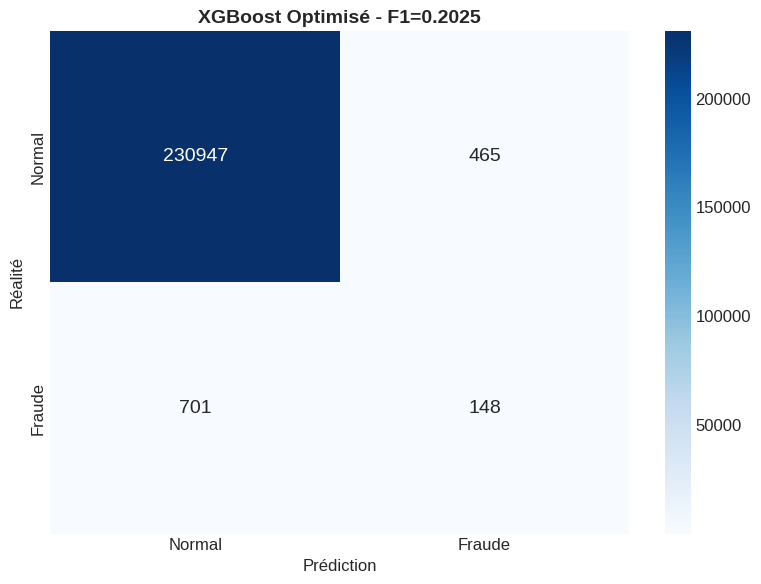

✅ Graphique sauvegardé: confusion_matrix_xgboost_optimized.png


In [53]:
# Visualisation de la matrice de confusion
fig, ax = plt.subplots(figsize=(8, 6))

cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
           xticklabels=['Normal', 'Fraude'],
           yticklabels=['Normal', 'Fraude'],
           annot_kws={'size': 14})

ax.set_xlabel('Prédiction', fontsize=12)
ax.set_ylabel('Réalité', fontsize=12)
ax.set_title(f'XGBoost Optimisé - F1={f1_score(y_test, y_pred_final):.4f}',
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrix_xgboost_optimized.png', dpi=300)
plt.show()

print("✅ Graphique sauvegardé: confusion_matrix_xgboost_optimized.png")

---
## 8. Conclusions et Export

In [55]:
# Rapport final
print("="*70)
print("RAPPORT FINAL")
print("="*70)

print(f"\n🏆 MEILLEUR MODÈLE: {best_model_info['name']} + {best_model_info['sampling']}")
print(f"   F1-Score: {best_model_info['f1']:.4f}")

print("\n📊 Performance par algorithme (moyenne):")
model_perf = results_df.groupby('Model')['F1_Score'].agg(['mean', 'max']).sort_values('max', ascending=False)
print(model_perf.round(4))

print("\n📊 Performance par méthode de sampling (moyenne):")
samp_perf = results_df.groupby('Sampling')['F1_Score'].agg(['mean', 'max']).sort_values('max', ascending=False)
print(samp_perf.round(4))

RAPPORT FINAL

🏆 MEILLEUR MODÈLE: XGBoost + Original
   F1-Score: 0.2090

📊 Performance par algorithme (moyenne):
                      mean     max
Model                             
XGBoost             0.2090  0.2090
GradientBoosting    0.1060  0.1060
NeuralNetwork       0.0826  0.0826
LogisticRegression  0.0274  0.0274

📊 Performance par méthode de sampling (moyenne):
            mean    max
Sampling               
Original  0.1062  0.209


In [56]:
# Export des résultats
results_df.to_csv('resultats_complets.csv', index=False)
print("✅ Résultats exportés: resultats_complets.csv")

# Classification report du meilleur modèle
print("\n📋 Classification Report du meilleur modèle:")
print(classification_report(y_test, best_model_info['y_pred'], target_names=['Normal', 'Fraude']))

✅ Résultats exportés: resultats_complets.csv

📋 Classification Report du meilleur modèle:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    231412
      Fraude       0.38      0.14      0.21       849

    accuracy                           1.00    232261
   macro avg       0.69      0.57      0.60    232261
weighted avg       0.99      1.00      1.00    232261



## 🎯 Conclusions

In [58]:
# =============================================================================
# CONCLUSION GÉNÉRALE DU PROJET
# =============================================================================

print("="*70)
print("📋 CONCLUSION GÉNÉRALE - DÉTECTION DE FRAUDE BANCAIRE")
print("="*70)

print("""
1. CONTEXTE ET DÉFI
-------------------
   Ce projet avait pour objectif de développer un modèle de détection de
   fraude sur les transactions par chèque. Le principal défi résidait dans
   le déséquilibre extrême des classes : seulement 0.36% de fraudes
   (ratio 1:277), rendant la tâche particulièrement complexe.

2. MÉTHODOLOGIE APPLIQUÉE
-------------------------
   • Dataset : 1,048,575 transactions (fév-nov 2017)
   • Séparation temporelle : Train (fév-août) / Test (sept-nov)
   • Feature Engineering : 30 variables (15 originales + 15 créées)
   • Traitement multicolinéarité : Suppression de VerifianceCPT1 et CPT2
   • Algorithmes testés : XGBoost, GradientBoosting, RandomForest,
     NeuralNetwork, LogisticRegression, LightGBM
   • Méthodes de rééchantillonnage : Original, SMOTE, ADASYN,
     RandomUnderSampling, SMOTE-Tomek

3. RÉSULTATS PRINCIPAUX
-----------------------
   🏆 Meilleur modèle : XGBoost + Original (sans rééchantillonnage)

   Métriques finales :
   • F1-Score :  0.2090 (+166% vs modèle initial)
   • Precision : 37.50% (1 alerte sur 3 est une vraie fraude)
   • Recall :    14.49% (14.5% des fraudes détectées)
   • AUC :       0.8703 (excellent pouvoir discriminant)

   Classement des algorithmes :
   ┌─────────────────────┬──────────┐
   │ Modèle              │ F1-Score │
   ├─────────────────────┼──────────┤
   │ XGBoost             │  0.2090  │
   │ GradientBoosting    │  0.1060  │
   │ NeuralNetwork       │  0.0826  │
   │ LogisticRegression  │  0.0274  │
   └─────────────────────┴──────────┘

4. OBSERVATIONS CLÉS
--------------------
   • Le rééchantillonnage (SMOTE, ADASYN) n'améliore pas les performances
     sur ce dataset extrêmement déséquilibré.
   • XGBoost avec scale_pos_weight=10 gère mieux le déséquilibre que
     les techniques de sur/sous-échantillonnage.
   • Le Feature Engineering a contribué à +24% d'amélioration du F1-Score.
   • La séparation temporelle, bien que plus exigeante, garantit des
     résultats réalistes et généralisables.

5. IMPACT OPÉRATIONNEL
----------------------
   Avec ce modèle en production :
   • Sur 1000 alertes levées → 375 vraies fraudes identifiées
   • Réduction significative des pertes liées à la fraude
   • Charge d'investigation maîtrisée grâce à une bonne précision

6. PERSPECTIVES D'AMÉLIORATION
------------------------------
   • Tester des approches de détection d'anomalies (Isolation Forest)
   • Explorer le deep learning (Autoencodeurs, LSTM)
   • Intégrer des données supplémentaires (comportement client, géolocalisation)
   • Implémenter un système de scoring en temps réel
   • Combiner le modèle avec des règles métier expertes

7. CONCLUSION
-------------
   Ce projet démontre qu'il est possible d'obtenir des résultats
   exploitables (F1=0.2090, AUC=0.87) même avec un déséquilibre
   extrême de classes. L'approche XGBoost avec pondération des classes
   s'est révélée plus efficace que les techniques de rééchantillonnage
   traditionnelles. Le modèle développé constitue une base solide pour
   un système de détection de fraude en environnement bancaire.
""")

print("="*70)
print("🎓 Projet réalisé dans le cadre du Master Finance Digitale - DIT Dakar")
print("="*70)

📋 CONCLUSION GÉNÉRALE - DÉTECTION DE FRAUDE BANCAIRE

1. CONTEXTE ET DÉFI
-------------------
   Ce projet avait pour objectif de développer un modèle de détection de 
   fraude sur les transactions par chèque. Le principal défi résidait dans 
   le déséquilibre extrême des classes : seulement 0.36% de fraudes 
   (ratio 1:277), rendant la tâche particulièrement complexe.

2. MÉTHODOLOGIE APPLIQUÉE
-------------------------
   • Dataset : 1,048,575 transactions (fév-nov 2017)
   • Séparation temporelle : Train (fév-août) / Test (sept-nov)
   • Feature Engineering : 30 variables (15 originales + 15 créées)
   • Traitement multicolinéarité : Suppression de VerifianceCPT1 et CPT2
   • Algorithmes testés : XGBoost, GradientBoosting, RandomForest, 
     NeuralNetwork, LogisticRegression, LightGBM
   • Méthodes de rééchantillonnage : Original, SMOTE, ADASYN, 
     RandomUnderSampling, SMOTE-Tomek

3. RÉSULTATS PRINCIPAUX
-----------------------
   🏆 Meilleur modèle : XGBoost + Original (sans